In [10]:
import matplotlib.pyplot as plt
import statistics as st
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from fpdf import FPDF
import pandas as pd
from math import *

In [15]:
f = open(r"C:\Users\alexf\OneDrive\Escritorio\alex\Fitness\Data.txt", "r")
data = f.readlines()
for i in range(len(data)):
    data[i] = data[i].split('\t')
dates = [datetime.datetime.strptime(data[i][0],"%d/%m/%Y").date() for i in range(len(data))]
weights = [float(data[i][1][:-1]) for i in range(len(data))]
days = [(dates[i]-dates[0]).days for i in range(len(dates))]
moving_average = [st.mean(weights[i:i+5]) for i in range(len(dates)-5)]
rates = [(moving_average[i+1]-moving_average[i])/(dates[i+1] - dates[i]).days for i in range(len(moving_average)-1)]

In [12]:
def regression(X, Y, Llim, Rlim, name):
    y = np.array(Y[Llim:Rlim])
    x = np.array(X[Llim:Rlim]).reshape((-1, 1))
    new_model = LinearRegression().fit(x, y)
    print(str(name))
    print('intercept:', new_model.intercept_)
    print('slope:', new_model.coef_, '\n')
    return new_model.coef_, new_model.intercept_

In [13]:
regression_cut_2021 = regression(days, weights, 65, 130, '2021 CUT')
regression_rate_2021 = regression(days, rates, 65, 130, '2021 RATE')
regression_offseason_2021 = regression(days, weights, 140, 180, '2021 offseason')
regression_2022 = regression(days, weights, 189, -1, '2022')

2021 CUT
intercept: 98.7069874096313
slope: [-0.06571955] 

2021 RATE
intercept: -0.6309561196196967
slope: [0.00159172] 

2021 offseason
intercept: 60.2269683281217
slope: [0.0305401] 

2022
intercept: 53.86224556781482
slope: [0.0416186] 



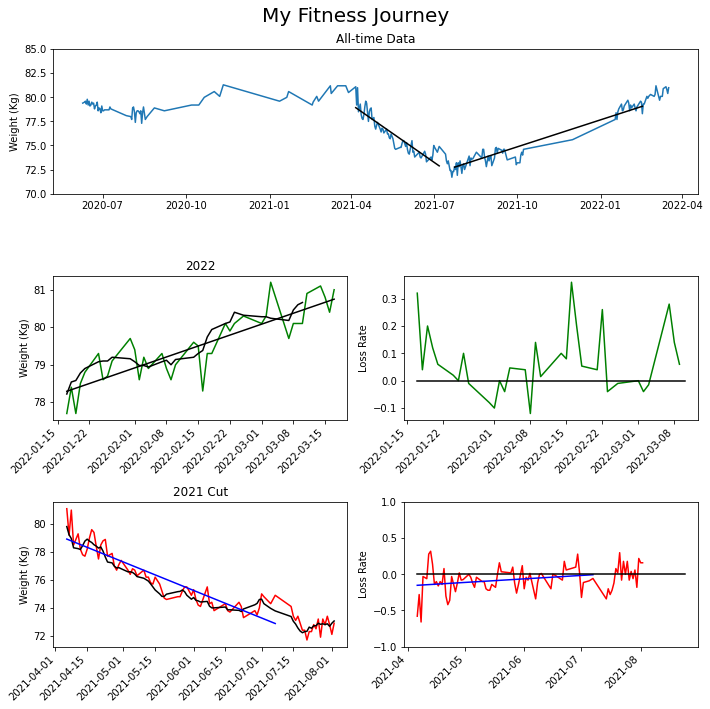

In [14]:
fig = plt.figure(figsize=(10, 10))
m, n = 65, 150
#ALL TIME DATA
ax1 = plt.subplot(311)
ax1.plot(dates,weights)
ax1.plot(dates[m:130], regression_cut_2021[0]*days[m:130] + regression_cut_2021[1] , 'k')
ax1.plot(dates[140:210], regression_offseason_2021[0]*days[140:210] + regression_offseason_2021[1], 'k')
ax1.set_title("All-time Data")
ax1.set_xlabel(" ")
ax1.set_ylabel("Weight (Kg)")
ax1.set_ylim(70,85)

#2022 
l = 189
ax3 = plt.subplot(323) 
ax3.plot(dates[l:],weights[l:], 'g')
ax3.plot(dates[l:-5],moving_average[l:], 'k')
ax3.plot(dates[l:],regression_2022[0]*days[l:] + regression_2022[1], 'k')
ax3.set_title("2022")
ax3.set_ylabel("Weight (Kg)")
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')
#Rates 2022
ax5 = plt.subplot(324)
ax5.plot(dates[l:-6],rates[l:], 'g')
ax5.plot([dates[l], dates[-6]], [0,0], 'k')
ax5.set_ylabel("Loss Rate")
for label in ax5.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')

#2021 CUT
ax2 = plt.subplot(325)
ax2.plot(dates[m:n],weights[m:n], 'r')
ax2.plot(dates[m:n],moving_average[m:n], 'k')
ax2.plot(dates[m:130], days[m:130]*regression_cut_2021[0] + regression_cut_2021[1], 'b')
ax2.set_title("2021 Cut")
ax2.set_ylabel("Weight (Kg)")
for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')
#Rates 2021
ax4 = plt.subplot(326)
ax4.plot(dates[m:n],rates[m:n], 'r')
ax4.plot(dates[m:130], days[m:130]*regression_rate_2021[0] + regression_rate_2021[1], 'b')
ax4.plot([dates[65], dates[160]], [0,0], 'k')
ax4.set_ylim(-1,1)
ax4.set_ylabel("Loss Rate")
for label in ax4.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')    
    
fig.suptitle('My Fitness Journey', size = 20)
fig.tight_layout()

## WEIGHT FOR REPORT

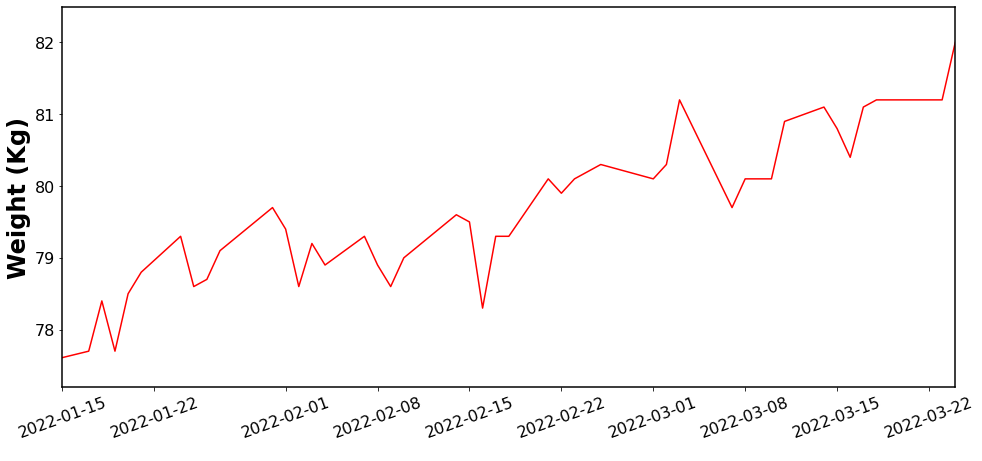

In [16]:
fig = plt.figure(figsize=(16, 7))
m, n = 65, 150
#ALL TIME DATA
ax = plt.subplot(111)
ax.plot(dates,weights, color = 'r')
ax.set_xlabel(" ")
ax.set_ylabel("Weight (Kg)", size=24, fontweight = 'bold')
ax.set_xlim(datetime.datetime(2022,1,15),datetime.date.today())
ax.set_ylim(min(weights[189:])-0.5,max(weights[189:])+0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', rotation = 20)
[x.set_linewidth(1.5) for x in ax.spines.values()]
fig.savefig('all_time.png')


# BODY MEASUREMENTS

In [20]:
body_measurements = pd.read_csv(r'C:\Users\alexf\OneDrive\Escritorio\alex\Fitness\Measurements & BodyFat Tracking Public.csv', sep=';')
body_measurements

,Date,Weight,Calves,Thigh,Hip,Waist,Chest,Shoulders,Forearms,Biceps,Neck
0,07/03/2022,79.7,36.9,56,103,84.0,108,127,28.5,34.00,41.0
1,23/03/2022,81.2,36.9,59,104,84.2,105,127,28.3,34.95,41.5


## Body Fat Percentage (BFP) estimation:

### Navy Seals Method in SI units:

$BFP = \frac{495}{ 1.0324 - 0.19077 \cdot\log_{10}(waist-neck)  + 0.15456\cdot\log_{10}(height)} - 450$

### BMI method:

$BFP = 1.20 × BMI + 0.23 \cdot Age - 16.2$


In [21]:
def BFP_navy(fila):
    return 495/(1.0324 - 0.19077*log10(fila['Waist'] - fila['Neck']) + 0.15456*log10(height)) - 450
def BFP_BMI(BMI):
    return 1.2*BMI + 0.23*age - 16.2
age = 24
height = 180
body_measurements['BMI'] = body_measurements['Weight']/(height/100)**2
body_measurements['BFP Navy'] = body_measurements.apply(BFP_navy, axis=1)
body_measurements['BFP BMI'] = body_measurements['BMI'].apply(BFP_BMI)
body_measurements['BFP Avg'] = (body_measurements['BFP Navy'] + body_measurements['BFP BMI'])/2
body_measurements['Fat Mass'] = body_measurements['Weight']*body_measurements['BFP Avg']/100
body_measurements['Lean Mass']= body_measurements['Weight'] - body_measurements['Fat Mass']
body_measurements['Mass at 12%'] = body_measurements['Lean Mass']/0.88 
body_measurements

,Date,Weight,Calves,Thigh,Hip,Waist,Chest,Shoulders,Forearms,Biceps,Neck,BMI,BFP Navy,BFP BMI,BFP Avg,Fat Mass,Lean Mass,Mass at 12%
0,07/03/2022,79.7,36.9,56,103,84.0,108,127,28.5,34.00,41.0,24.598765,12.894498,18.838519,15.866508,12.645607,67.054393,76.198174
1,23/03/2022,81.2,36.9,59,104,84.2,105,127,28.3,34.95,41.5,25.061728,12.643547,19.394074,16.018810,13.007274,68.192726,77.491734


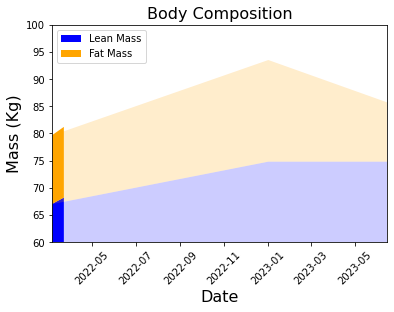

In [22]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot()
ax.stackplot([datetime.datetime.strptime(body_measurements.Date.iloc[i], '%d/%m/%Y') for i in range(len(body_measurements.Date))], body_measurements['Lean Mass'], body_measurements['Fat Mass'],
              labels=['Lean Mass', 'Fat Mass'], alpha=1, colors = ['blue','orange'])
ax.stackplot([datetime.date(2022,3,7),datetime.date(2023,1,1),datetime.date(2023,6,30)], [67,74.8,74.8], [12.646,18.7,10.2],
             alpha=0.2, colors = ['blue','orange'])
ax.legend(loc='upper left')
ax.set_title('Body Composition', size = 16)
ax.set_xlabel('Date', size = 16)
ax.tick_params(axis ='x', rotation = 45)
ax.set_ylabel('Mass (Kg)', size = 16)
ax.set_ylim([60,100])
ax.set_xlim(datetime.datetime(2022,3,7),datetime.datetime(2023,6,15))
fig.savefig('body_composition.png')

## Body Measurements Plots:

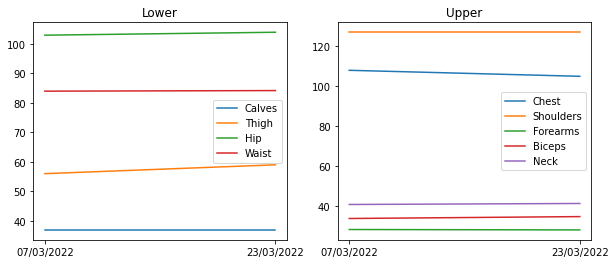

In [23]:
fig = plt.figure(figsize = (10,4))
ax1 = plt.subplot(121)
ax1.set_title('Lower')
ax1.plot(body_measurements.Date, body_measurements.Calves, label='Calves')
ax1.plot(body_measurements.Date, body_measurements.Thigh, label='Thigh')
ax1.plot(body_measurements.Date, body_measurements.Hip, label='Hip')
ax1.plot(body_measurements.Date, body_measurements.Waist, label='Waist')
ax1.legend()
ax2 = plt.subplot(122)
ax2.set_title('Upper')
ax2.plot(body_measurements.Date, body_measurements.Chest, label='Chest')
ax2.plot(body_measurements.Date, body_measurements.Shoulders, label='Shoulders')
ax2.plot(body_measurements.Date, body_measurements.Forearms, label='Forearms')
ax2.plot(body_measurements.Date, body_measurements.Biceps, label='Biceps')
ax2.plot(body_measurements.Date, body_measurements.Neck, label='Neck')
ax2.legend()
fig.savefig('measurements.png')

# TRAINING LOG

In [24]:
workouts = pd.read_csv(r'C:\Users\alexf\OneDrive\Escritorio\alex\Fitness\workouts.csv')
workouts = workouts.drop(['end_time', 'description','superset_id','exercise_notes', 'distance_km', 'duration_seconds'], axis = 1)
movements = {
    'hinge':['Deadlift (Barbell)', 'Seated Leg Curl (Machine)', 'Hip Abduction (Machine)', 'Hip Adduction (Machine)'],
    'squad':['Bulgarian Split Squat', 'Leg Press Horizontal (Machine)', 'Squat (Barbell)'],
    'row':['Bent Over Row (Barbell)', 'Seated Cable Row', 'Shrug (Dumbbell)'],
    'pull':['Lat Pulldown (Cable)', 'Pull Up', 'Chin Up'],
    'push':['Bench Press (Barbell)', 'Chest Dip', 'Push Up', 'Cable Fly Crossovers', 'Incline Bench Press (Barbell)', 'Incline Bench Press (Dumbbell)', 'Low Cable Fly Crossovers'],
    'press':[],
    'biceps':['Alternating Bicep Curls (Dumbbell)', 'Seated Incline Curl (Dumbbell)', 'Bicep Curl (Dumbbell)', 'EZ Bar Biceps Curl', 'Hammer Curl (Dumbbell)', 'Preacher Curl (Barbell)'],
    'triceps':['Triceps Cable Kickback', 'Triceps Extension (Cable)', 'Triceps Pushdown'],
    'shoulders':['Face Pull', 'Lateral Raise (Dumbbell)', 'Rear Delt Reverse Fly (Machine)'],
    'core':['Ab Wheel', 'Knee Raise Parallel Bars', 'Lying Leg Raise', 'Crunch', 'Sit Up (Weighted)'],
    'calvs':['Calf Extension (Machine)']
            }
workouts.head(1)

,title,start_time,exercise_title,set_index,set_type,weight_kg,reps
0,Pull,"7 Mar 2022, 15:20",Pull Up,0,normal,NaN,8.0


In [ ]:
a = workouts[('exercise_title' in movements['push'])].groupby("start_time").agg({'set_index': 'count', 'weight_kg':'max', 'reps':'mean'})
a.fillna(0)

In [25]:
'Deadlift (Barbell)' in movements['hinge']

True

# BUILDING PDF REPORT

In [26]:
pdf_w=210
pdf_h=297
class PDF(FPDF):
    def lines(self):
        self.set_line_width(0.0)
        #self.line(0,pdf_h/2,210,pdf_h/2) #line(x1,y1,x2,y2)
        self.set_fill_color(255, 153, 153) #light red
        self.rect(5.0, 35.0, 200.0,252.0, 'DF')
        self.set_fill_color(255,255,255) #White
        self.rect(5.0, 35.0, 40.0,15.0, 'DF')
    def titles(self,text, x, y):
        self.set_xy(x, y)
        self.set_font('Arial', 'B', 32)
        self.set_text_color(220, 50, 50)
        self.cell(w=210.0, h=40.0, align='C', txt=text, border=0)
    def subtitles(self,text, x, y):
        self.set_xy(x, y)
        self.set_font('Arial', 'B', 16)
        self.set_text_color(220, 50, 50)
        self.cell(w=210.0, h=40.0, align='L', txt=text, border=0)
    def some_text(self,text, x, y):
        self.set_xy(x, y)
        self.set_font('Arial', 'B', 16)
        self.set_text_color(220, 50, 50)
        self.cell(w=210.0, h=40.0, align='L', txt=text, border=0)
    def small_text(self,text, x, y):
        self.set_xy(x, y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(0, 0, 0)
        self.cell(w=210.0, h=40.0, align='L', txt=text, border=0)
pdf = PDF(orientation='P', unit='mm', format='A4') #(default)
pdf.add_page()
pdf.lines()
pdf.titles("MY FITNESS JOURNEY 2022", 0.0, 0.0)
pdf.subtitles("WEIGHT", 13, 23)
pdf.image('all_time.png', 5, 70, w=200)
pdf.image('measurements.png', 5, 200, w=200)
pdf.set_fill_color(255,255,255)
pdf.rect(20,170,170,20, 'DF')
pdf.some_text('Mass:'+str(body_measurements.Weight.iloc[-1]) +'Kg', 25, 160)
pdf.some_text('BMI:'+str(round(body_measurements.BMI.iloc[-1],2)) , 95, 160)
pdf.some_text('BFP:'+str(round(body_measurements['BFP Avg'].iloc[-1],2)) +'%', 150, 160)
pdf.small_text('GOAL: Recom to 85Kg with 10%-12% of body fat in 18 months.', 40, 45)

In [27]:
pdf.output("test.pdf","F")

''